In [7]:
import os
import pandas as pd
import datetime
import json
import seaborn as sns
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
sns.set_style("whitegrid")
sns.set_context("talk")

In [3]:
with open("./word_count.json", 'r') as f:
    word_cnt = json.load(f)

In [4]:
with open("./official_words.txt", 'r') as f:
# with open("./official_words_2.txt", 'r') as f:
    official_words = set([line.strip() for line in f.readlines()])

In [5]:
iters = 0
word_arr = {}
for word in word_cnt.keys():
    if word.encode('utf-8') in official_words:
        count = word_cnt[word]
        df = pd.DataFrame({"date": count.keys(), "count": count.values()})
        df.index = df["date"].map(lambda x: datetime.datetime.strptime(str(x), "%Y-%m-%d"))
        df.sort_index(inplace=True)
        arr = []
        for i in df.index:
            if len(arr) == 0:
                arr.append(0)
            else:
#                 print df["count"][i], df[df.index <= i]["count"].mean(), df[df.index <= i]["count"].std()
                arr.append((df["count"][i] - df[df.index <= i]["count"].mean()) / df[df.index <= i]["count"].std())
#         arr = df["count"]
#         arr = (arr - np.mean(arr)) / np.std(arr)
        word_arr[word] = pd.DataFrame(np.array(arr), index=df.index)

In [6]:
arr = word_arr[u"人民币"]

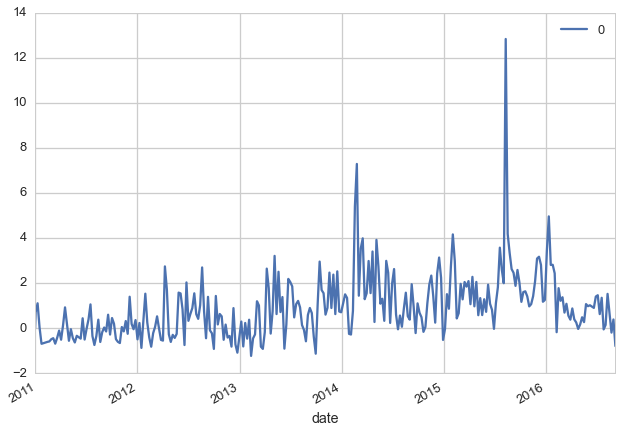

In [7]:
arr.plot()

# 读取中证流通数据

In [8]:
csi = pd.read_csv("./000902.csv")
csi.columns = ["date", "open", "high", "low", "close", "volume", "volume2"]
csi = csi.dropna()
csi.index = csi["date"]
csi_df = csi["close"]

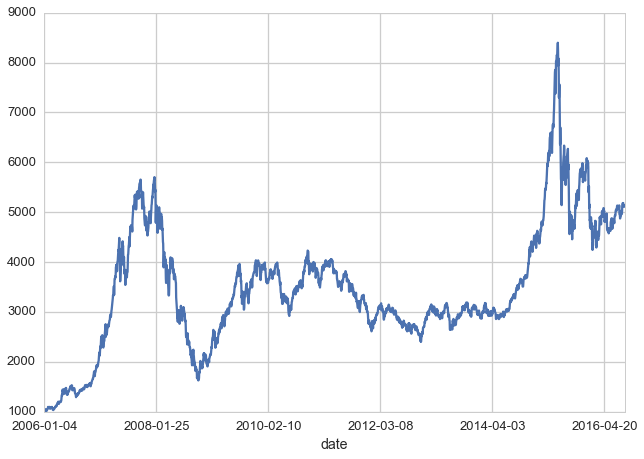

In [9]:
csi_df.plot()

In [10]:
select_date = []
stock_return = []
log_return = []
for i in range(1, arr.shape[0]):
    date = arr.index[i]
    day = date.strftime("%Y-%m-%d")
    next_date = date + datetime.timedelta(4)
    next_day = next_date.strftime("%Y-%m-%d")
    next_next_date = next_date + datetime.timedelta(7)
    next_next_day = next_next_date.strftime("%Y-%m-%d")
    if (next_day in csi_df.index) and (next_next_day in csi_df.index):
        ret = (csi_df[next_next_day] - csi_df[next_day]) / csi_df[next_day]
        select_date.append(date)
        stock_return.append(ret * 100)
        log_return.append(np.log(csi_df[next_next_day] / csi_df[next_day]) * 100)
#         print day, next_day, next_next_day, sh_df[next_day], sh_df[next_next_day], ret * 100

In [11]:
return_df = pd.DataFrame({"return": stock_return}, index=select_date)
return_df = return_df.sort_index()

In [12]:
print return_df.head()

              return
2011-01-03 -3.396570
2011-01-10 -3.771688
2011-01-17  1.236375
2011-02-14  0.364326
2011-02-21  1.711926


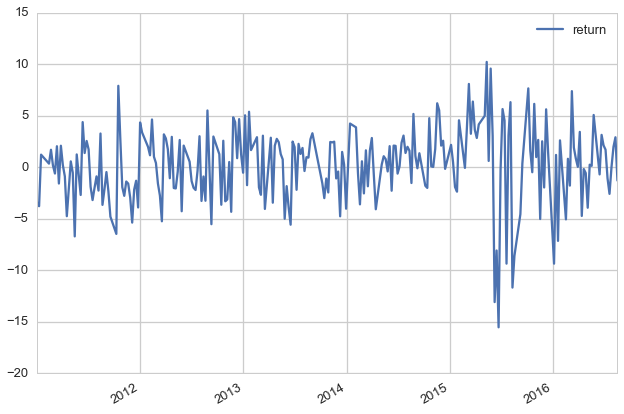

In [13]:
return_df.plot()

In [14]:
log_return_df = pd.DataFrame({"return": log_return}, index=select_date)
log_return_df = log_return_df.sort_index()

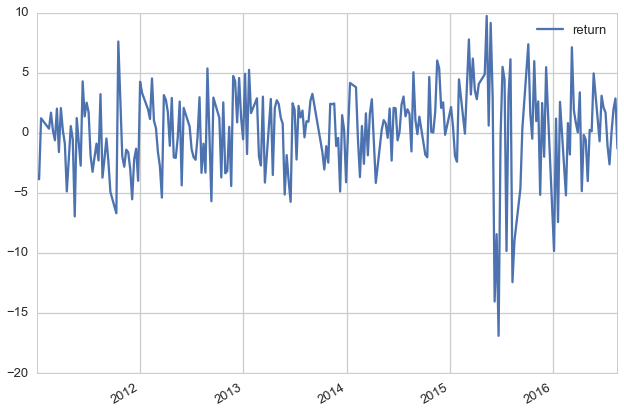

In [15]:
log_return_df.plot()

# 词频与波动率模型

In [16]:
for word in word_arr.keys():
    return_df[word] = word_arr[word]
    log_return_df[word] = word_arr[word]

In [17]:
return_df = return_df.drop(return_df.index[[0, 1]])
log_return_df = log_return_df.drop(return_df.index[[0, 1]])

In [18]:
return_na_df = return_df.fillna(0)
log_return_df = log_return_df.fillna(0)
print return_na_df.shape

(250, 54)


In [19]:
# x = return_na_df[return_na_df.columns[1:]]
# y = return_na_df["return"]
x = log_return_df[log_return_df.columns[1:]]
y = log_return_df["return"]

In [20]:
lasso = Lasso(alpha=0.2)
lasso.fit(x.as_matrix(), np.array(y))

/Library/Python/2.7/site-packages/sklearn/linear_model/base.py:400: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


Lasso(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)

### Lasso系数不为0的词

In [21]:
for i in np.where(lasso.coef_ != 0)[0]:
    print return_na_df[return_na_df.columns[1:]].columns[i], lasso.coef_[i]

通胀 0.21130408646
限制 -0.0534239237504
反弹 0.0778798399786
油价 0.0159016718701
方案 -0.0778410969448
原油 0.0279913585617
危机 -0.0593671818839
不得 -0.178478829675
下行 0.164874640474
证券 0.214261706711
利率 0.00372022495212
收入 0.168971063906
波动 -0.179971524518
降息 0.206768892049
规范 0.153582092707
加息 0.170153464302
跌幅 -0.0893190306449
关注 0.044728483652
人民币 -0.470240913298


### 计算$R^2$

In [22]:
pred = lasso.predict(x)
R2 = r2_score(y, pred)
# print pred
print R2

0.152059159108


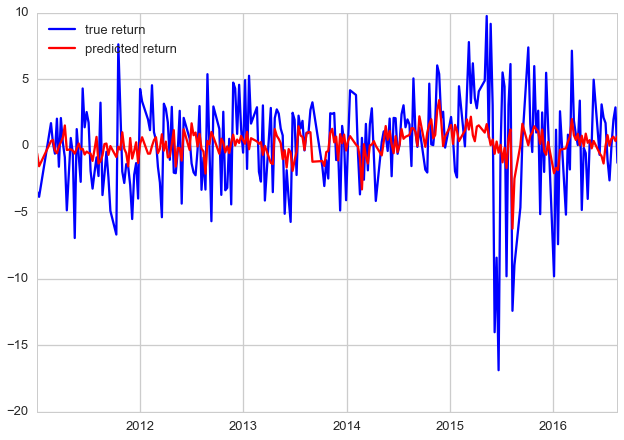

In [23]:
plt.plot(y.index, y.values, c='b')
plt.plot(y.index, pred, c='r')
plt.legend(['true return', 'predicted return'], loc='upper left')

In [24]:
np.corrcoef(y.values, pred)

array([[ 1.        ,  0.41347908],
       [ 0.41347908,  1.        ]])

# 其他regression方法

In [25]:
lm = LinearRegression(normalize=True)
lm.fit(x.as_matrix(), np.array(y))

LinearRegression(copy_X=True, fit_intercept=True, normalize=True)

In [26]:
pred = lm.predict(x)
R2 = r2_score(y, pred)
# print pred
print R2

0.267569765587


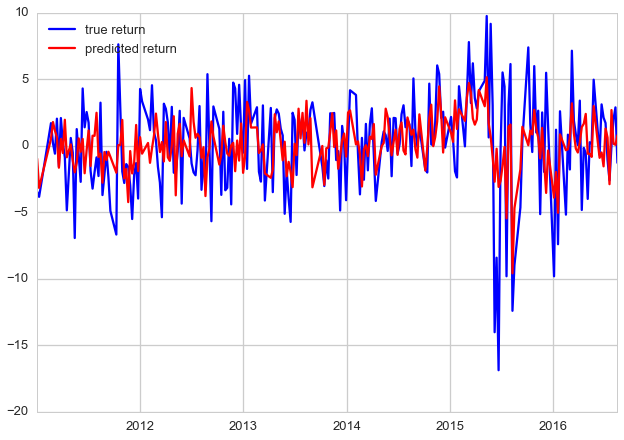

In [27]:
plt.plot(y.index, y.values, c='b')
plt.plot(y.index, pred, c='r')
plt.legend(['true return', 'predicted return'], loc='upper left')

In [28]:
np.corrcoef(y.values, pred)

array([[ 1.        ,  0.51727146],
       [ 0.51727146,  1.        ]])

In [29]:
rf = RandomForestRegressor()
rf.fit(x.as_matrix(), np.array(y))

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
           random_state=None, verbose=0)

In [30]:
pred = rf.predict(x)
R2 = r2_score(y, pred)
# print pred
print R2

0.81843105826


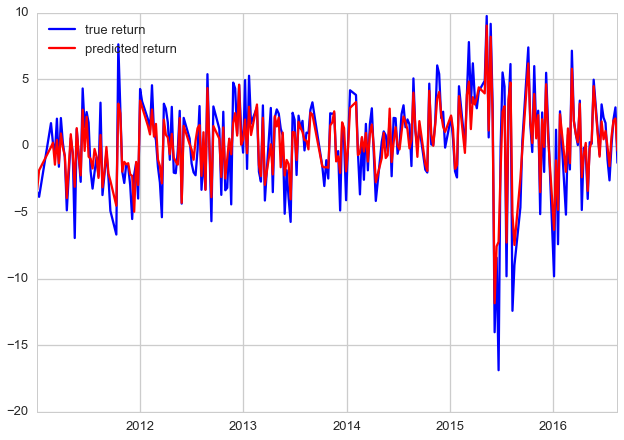

In [31]:
plt.plot(y.index, y.values, c='b')
plt.plot(y.index, pred, c='r')
plt.legend(['true return', 'predicted return'], loc='upper left')

In [32]:
np.corrcoef(y.values, pred)

array([[ 1.       ,  0.9337274],
       [ 0.9337274,  1.       ]])

# 分类模型

In [33]:
x.shape

(250, 53)

In [34]:
ob = y.copy()
k = 2
ob[(ob > -k) & (ob < k)] = 0
ob[(ob < -k) | (ob > k)] = 1

In [35]:
sum(ob == 1)

142

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x.as_matrix(), ob, test_size=0.33, random_state=42)

In [37]:
gnb = GaussianNB()

In [38]:
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [39]:
accuracy_score(y_test, y_pred)

0.51807228915662651

In [40]:
roc_auc_score(y_test, y_pred)

0.52076023391812865

In [41]:
rf = RandomForestClassifier()

In [42]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [43]:
accuracy_score(y_test, y_pred)

0.48192771084337349

In [44]:
roc_auc_score(y_test, y_pred)

0.47719298245614028

# 词的PCA

In [321]:
pca = PCA(n_components=2)
X_r = pca.fit(x.as_matrix()).transform(x.as_matrix())

In [322]:
X_r.shape

(250, 2)